# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 13 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=6,groups=1,dilation=1,bias=True) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=w[0]
        #w=torch.randn(w[0].shape).cuda()*1
        
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        
        #w=self.scaleLayer(w)  #自动缩放层
        
        if a>0.37:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
        
        if a>0.37:
            print(self.conv1D.weight.shape)
            print(self.conv1D.weight)
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.277880, Accuracy: 19.53
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.429526, Accuracy: 9.38
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.330590, Accuracy: 8.59
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.282691, Accuracy: 12.11
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.205739, Accuracy: 14.06
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.207560, Accuracy: 17.97
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.047475, Accuracy: 16.02
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.169926, Accuracy: 18.36
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.147728, Accuracy: 17.58
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.140962, Accuracy: 17.97
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.074703, Accuracy: 17.19
Train Epoch: 0 [14080/50000 (31%)]	Loss: 2.040472, Accuracy: 21.88
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.903797, Accuracy: 22.27
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.971578, Accuracy: 23.05
Train Epoch: 0 [17920/50000 (40%)]	Loss: 2.054471, Accuracy: 23.83
Train Epoch:

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.013906, Accuracy: 58.98
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.020652, Accuracy: 63.28
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.188315, Accuracy: 58.20
Train Epoch: 3 [17920/50000 (40%)]	Loss: 0.968240, Accuracy: 66.41
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.084206, Accuracy: 63.28
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.033608, Accuracy: 60.55
Train Epoch: 3 [21760/50000 (48%)]	Loss: 1.117482, Accuracy: 60.16
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.104042, Accuracy: 60.16
Train Epoch: 3 [24320/50000 (54%)]	Loss: 1.137608, Accuracy: 55.47
Train Epoch: 3 [25600/50000 (57%)]	Loss: 1.103613, Accuracy: 63.28
Train Epoch: 3 [26880/50000 (60%)]	Loss: 1.191219, Accuracy: 55.47
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.165906, Accuracy: 53.52
Train Epoch: 3 [29440/50000 (65%)]	Loss: 0.995276, Accuracy: 64.84
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.214143, Accuracy: 59.38
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.010012, Accuracy: 6

Train Epoch: 6 [26880/50000 (60%)]	Loss: 0.724504, Accuracy: 75.00
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.688295, Accuracy: 74.61
Train Epoch: 6 [29440/50000 (65%)]	Loss: 0.651414, Accuracy: 77.73
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.618136, Accuracy: 76.95
Train Epoch: 6 [32000/50000 (71%)]	Loss: 0.736703, Accuracy: 76.95
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.721542, Accuracy: 75.39
Train Epoch: 6 [34560/50000 (77%)]	Loss: 0.684353, Accuracy: 78.91
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.786730, Accuracy: 73.44
torch.Size([1024, 1, 1])
tensor([[[ 0.0000]],

        [[ 0.0580]],

        [[ 0.0453]],

        ...,

        [[ 0.0001]],

        [[ 0.0115]],

        [[ 0.0027]]], device='cuda:0')
Parameter containing:
tensor([[[-0.6850]]], device='cuda:0')
torch.Size([896, 1, 13])
Parameter containing:
tensor([[[-1.2088e-01, -1.1151e-01,  3.0547e-02,  ..., -1.0417e-01,
           9.7985e-02,  8.6106e-02]],

        [[-6.9800e-02,  1.7556e-02,  1.3149e-01,  ..., -6.456

Train Epoch: 9 [8960/50000 (20%)]	Loss: 0.560158, Accuracy: 82.03
Train Epoch: 9 [10240/50000 (23%)]	Loss: 0.631529, Accuracy: 76.17
Train Epoch: 9 [11520/50000 (26%)]	Loss: 0.648653, Accuracy: 80.86
Train Epoch: 9 [12800/50000 (28%)]	Loss: 0.636764, Accuracy: 79.69
Train Epoch: 9 [14080/50000 (31%)]	Loss: 0.595728, Accuracy: 81.25
Train Epoch: 9 [15360/50000 (34%)]	Loss: 0.588448, Accuracy: 79.69
Train Epoch: 9 [16640/50000 (37%)]	Loss: 0.598464, Accuracy: 80.86
Train Epoch: 9 [17920/50000 (40%)]	Loss: 0.689400, Accuracy: 77.34
Train Epoch: 9 [19200/50000 (43%)]	Loss: 0.661556, Accuracy: 76.17
Train Epoch: 9 [20480/50000 (45%)]	Loss: 0.585258, Accuracy: 80.08
Train Epoch: 9 [21760/50000 (48%)]	Loss: 0.656069, Accuracy: 78.12
Train Epoch: 9 [23040/50000 (51%)]	Loss: 0.643190, Accuracy: 74.61
Train Epoch: 9 [24320/50000 (54%)]	Loss: 0.537902, Accuracy: 82.03
Train Epoch: 9 [25600/50000 (57%)]	Loss: 0.653708, Accuracy: 78.52
Train Epoch: 9 [26880/50000 (60%)]	Loss: 0.593687, Accuracy: 81

Train Epoch: 12 [19200/50000 (43%)]	Loss: 0.424519, Accuracy: 85.94
Train Epoch: 12 [20480/50000 (45%)]	Loss: 0.544625, Accuracy: 80.86
Train Epoch: 12 [21760/50000 (48%)]	Loss: 0.560217, Accuracy: 80.86
Train Epoch: 12 [23040/50000 (51%)]	Loss: 0.643271, Accuracy: 76.95
Train Epoch: 12 [24320/50000 (54%)]	Loss: 0.548786, Accuracy: 82.42
Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.487738, Accuracy: 82.03
Train Epoch: 12 [26880/50000 (60%)]	Loss: 0.480257, Accuracy: 83.20
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.435130, Accuracy: 83.59
Train Epoch: 12 [29440/50000 (65%)]	Loss: 0.558379, Accuracy: 80.47
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.523429, Accuracy: 83.20
Train Epoch: 12 [32000/50000 (71%)]	Loss: 0.538007, Accuracy: 82.03
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.489861, Accuracy: 82.03
Train Epoch: 12 [34560/50000 (77%)]	Loss: 0.604006, Accuracy: 80.86
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.571825, Accuracy: 79.69
Train Epoch: 12 [37120/50000 (82%)]	Loss: 0.5767

Train Epoch: 15 [28160/50000 (62%)]	Loss: 0.416913, Accuracy: 86.72
Train Epoch: 15 [29440/50000 (65%)]	Loss: 0.494665, Accuracy: 83.98
Train Epoch: 15 [30720/50000 (68%)]	Loss: 0.618329, Accuracy: 79.69
Train Epoch: 15 [32000/50000 (71%)]	Loss: 0.440699, Accuracy: 84.38
Train Epoch: 15 [33280/50000 (74%)]	Loss: 0.597733, Accuracy: 78.91
Train Epoch: 15 [34560/50000 (77%)]	Loss: 0.557685, Accuracy: 80.86
Train Epoch: 15 [35840/50000 (80%)]	Loss: 0.438397, Accuracy: 83.59
Train Epoch: 15 [37120/50000 (82%)]	Loss: 0.518442, Accuracy: 80.86
Train Epoch: 15 [38400/50000 (85%)]	Loss: 0.444560, Accuracy: 84.38
Train Epoch: 15 [39680/50000 (88%)]	Loss: 0.555189, Accuracy: 81.64
Train Epoch: 15 [40960/50000 (91%)]	Loss: 0.385056, Accuracy: 88.28
Train Epoch: 15 [42240/50000 (94%)]	Loss: 0.582851, Accuracy: 80.47
Train Epoch: 15 [43520/50000 (97%)]	Loss: 0.393119, Accuracy: 83.98
Train Epoch: 15 [35000/50000 (99%)]	Loss: 0.372339, Accuracy: 88.50

Validation set: Average loss: 0.6590, Accuracy:

Train Epoch: 18 [38400/50000 (85%)]	Loss: 0.417632, Accuracy: 85.94
Train Epoch: 18 [39680/50000 (88%)]	Loss: 0.366015, Accuracy: 88.67
Train Epoch: 18 [40960/50000 (91%)]	Loss: 0.416291, Accuracy: 84.77
Train Epoch: 18 [42240/50000 (94%)]	Loss: 0.412037, Accuracy: 87.50
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.512751, Accuracy: 83.98
Train Epoch: 18 [35000/50000 (99%)]	Loss: 0.586632, Accuracy: 79.00

Validation set: Average loss: 0.5177, Accuracy: 4100/5000 (82.00%)

the time of this epoch:[37.51528453826904 s]

Test set: Average loss: 0.5499, Accuracy: 8130/10000 (81.30%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.453712, Accuracy: 83.98
Train Epoch: 19 [1280/50000 (3%)]	Loss: 0.387556, Accuracy: 84.77
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.402804, Accuracy: 86.33
Train Epoch: 19 [3840/50000 (9%)]	Loss: 0.419550, Accuracy: 86.33
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.441846, Accuracy: 85.16
Train Epoch: 19 [6400/50000 (14%)]	Loss: 0.391237, Accuracy: 87.50
Train Epoch: 19 [76

Train Epoch: 22 [0/50000 (0%)]	Loss: 0.334824, Accuracy: 89.06
Train Epoch: 22 [1280/50000 (3%)]	Loss: 0.479320, Accuracy: 81.25
Train Epoch: 22 [2560/50000 (6%)]	Loss: 0.429871, Accuracy: 86.72
Train Epoch: 22 [3840/50000 (9%)]	Loss: 0.438722, Accuracy: 87.11
Train Epoch: 22 [5120/50000 (11%)]	Loss: 0.314900, Accuracy: 88.67
Train Epoch: 22 [6400/50000 (14%)]	Loss: 0.425302, Accuracy: 83.98
Train Epoch: 22 [7680/50000 (17%)]	Loss: 0.482723, Accuracy: 84.38
Train Epoch: 22 [8960/50000 (20%)]	Loss: 0.466279, Accuracy: 85.16
Train Epoch: 22 [10240/50000 (23%)]	Loss: 0.459994, Accuracy: 83.20
Train Epoch: 22 [11520/50000 (26%)]	Loss: 0.410153, Accuracy: 85.94
Train Epoch: 22 [12800/50000 (28%)]	Loss: 0.426492, Accuracy: 83.98
Train Epoch: 22 [14080/50000 (31%)]	Loss: 0.494438, Accuracy: 82.03
Train Epoch: 22 [15360/50000 (34%)]	Loss: 0.464293, Accuracy: 82.03
Train Epoch: 22 [16640/50000 (37%)]	Loss: 0.395051, Accuracy: 84.38
Train Epoch: 22 [17920/50000 (40%)]	Loss: 0.370836, Accuracy: 8


Test set: Average loss: 0.6393, Accuracy: 7901/10000 (79.01%)

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.333862, Accuracy: 89.06
Train Epoch: 25 [1280/50000 (3%)]	Loss: 0.296352, Accuracy: 89.06
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.471766, Accuracy: 85.94
Train Epoch: 25 [3840/50000 (9%)]	Loss: 0.388712, Accuracy: 86.33
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.464857, Accuracy: 82.03
Train Epoch: 25 [6400/50000 (14%)]	Loss: 0.428587, Accuracy: 83.98
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.450166, Accuracy: 87.89
Train Epoch: 25 [8960/50000 (20%)]	Loss: 0.483406, Accuracy: 84.77
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.407021, Accuracy: 85.94
Train Epoch: 25 [11520/50000 (26%)]	Loss: 0.446588, Accuracy: 85.55
Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.401924, Accuracy: 85.94
Train Epoch: 25 [14080/50000 (31%)]	Loss: 0.426115, Accuracy: 86.33
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.344239, Accuracy: 87.50
Train Epoch: 25 [16640/50000 (37%)]	Loss: 0.424981, Accuracy: 84.77

Train Epoch: 28 [8960/50000 (20%)]	Loss: 0.398004, Accuracy: 88.28
Train Epoch: 28 [10240/50000 (23%)]	Loss: 0.399015, Accuracy: 86.33
Train Epoch: 28 [11520/50000 (26%)]	Loss: 0.317749, Accuracy: 89.84
Train Epoch: 28 [12800/50000 (28%)]	Loss: 0.373737, Accuracy: 86.33
Train Epoch: 28 [14080/50000 (31%)]	Loss: 0.496992, Accuracy: 83.98
Train Epoch: 28 [15360/50000 (34%)]	Loss: 0.412754, Accuracy: 86.33
Train Epoch: 28 [16640/50000 (37%)]	Loss: 0.333801, Accuracy: 89.45
Train Epoch: 28 [17920/50000 (40%)]	Loss: 0.442488, Accuracy: 83.20
Train Epoch: 28 [19200/50000 (43%)]	Loss: 0.469724, Accuracy: 88.28
Train Epoch: 28 [20480/50000 (45%)]	Loss: 0.409573, Accuracy: 86.72
Train Epoch: 28 [21760/50000 (48%)]	Loss: 0.445622, Accuracy: 84.77
Train Epoch: 28 [23040/50000 (51%)]	Loss: 0.404650, Accuracy: 87.50
Train Epoch: 28 [24320/50000 (54%)]	Loss: 0.475848, Accuracy: 84.38
Train Epoch: 28 [25600/50000 (57%)]	Loss: 0.360646, Accuracy: 87.11
Train Epoch: 28 [26880/50000 (60%)]	Loss: 0.53940

Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.435614, Accuracy: 84.77
Train Epoch: 31 [19200/50000 (43%)]	Loss: 0.434079, Accuracy: 87.50
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.326178, Accuracy: 90.23
Train Epoch: 31 [21760/50000 (48%)]	Loss: 0.463527, Accuracy: 83.20
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.528534, Accuracy: 80.86
Train Epoch: 31 [24320/50000 (54%)]	Loss: 0.359527, Accuracy: 89.45
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.350485, Accuracy: 85.55
Train Epoch: 31 [26880/50000 (60%)]	Loss: 0.323901, Accuracy: 88.67
Train Epoch: 31 [28160/50000 (62%)]	Loss: 0.480186, Accuracy: 85.55
Train Epoch: 31 [29440/50000 (65%)]	Loss: 0.445292, Accuracy: 85.16
Train Epoch: 31 [30720/50000 (68%)]	Loss: 0.379208, Accuracy: 87.89
Train Epoch: 31 [32000/50000 (71%)]	Loss: 0.407342, Accuracy: 85.16
Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.320852, Accuracy: 89.06
Train Epoch: 31 [34560/50000 (77%)]	Loss: 0.531751, Accuracy: 83.59
Train Epoch: 31 [35840/50000 (80%)]	Loss: 0.4267


Test set: Average loss: 0.6921, Accuracy: 7795/10000 (77.95%)

Train Epoch: 33 [0/50000 (0%)]	Loss: 0.390722, Accuracy: 85.55
Train Epoch: 33 [1280/50000 (3%)]	Loss: 0.344308, Accuracy: 88.67
Train Epoch: 33 [2560/50000 (6%)]	Loss: 0.298352, Accuracy: 90.23
Train Epoch: 33 [3840/50000 (9%)]	Loss: 0.415371, Accuracy: 81.64
Train Epoch: 33 [5120/50000 (11%)]	Loss: 0.403843, Accuracy: 85.16
Train Epoch: 33 [6400/50000 (14%)]	Loss: 0.338521, Accuracy: 88.67
Train Epoch: 33 [7680/50000 (17%)]	Loss: 0.385043, Accuracy: 86.33
Train Epoch: 33 [8960/50000 (20%)]	Loss: 0.317506, Accuracy: 87.50
Train Epoch: 33 [10240/50000 (23%)]	Loss: 0.394144, Accuracy: 85.55
Train Epoch: 33 [11520/50000 (26%)]	Loss: 0.383834, Accuracy: 87.50
Train Epoch: 33 [12800/50000 (28%)]	Loss: 0.330753, Accuracy: 89.84
Train Epoch: 33 [14080/50000 (31%)]	Loss: 0.250021, Accuracy: 91.80
Train Epoch: 33 [15360/50000 (34%)]	Loss: 0.386803, Accuracy: 84.77
Train Epoch: 33 [16640/50000 (37%)]	Loss: 0.413633, Accuracy: 84.38

Train Epoch: 36 [8960/50000 (20%)]	Loss: 0.418082, Accuracy: 85.55
Train Epoch: 36 [10240/50000 (23%)]	Loss: 0.355765, Accuracy: 87.11
Train Epoch: 36 [11520/50000 (26%)]	Loss: 0.414766, Accuracy: 83.20
Train Epoch: 36 [12800/50000 (28%)]	Loss: 0.496954, Accuracy: 82.42
Train Epoch: 36 [14080/50000 (31%)]	Loss: 0.417542, Accuracy: 84.77
Train Epoch: 36 [15360/50000 (34%)]	Loss: 0.341714, Accuracy: 87.89
Train Epoch: 36 [16640/50000 (37%)]	Loss: 0.442613, Accuracy: 84.77
Train Epoch: 36 [17920/50000 (40%)]	Loss: 0.386321, Accuracy: 85.55
Train Epoch: 36 [19200/50000 (43%)]	Loss: 0.369552, Accuracy: 89.45
Train Epoch: 36 [20480/50000 (45%)]	Loss: 0.310426, Accuracy: 89.45
Train Epoch: 36 [21760/50000 (48%)]	Loss: 0.369789, Accuracy: 86.72
Train Epoch: 36 [23040/50000 (51%)]	Loss: 0.322626, Accuracy: 89.06
Train Epoch: 36 [24320/50000 (54%)]	Loss: 0.374266, Accuracy: 86.33
Train Epoch: 36 [25600/50000 (57%)]	Loss: 0.375506, Accuracy: 89.45
Train Epoch: 36 [26880/50000 (60%)]	Loss: 0.34880

Train Epoch: 39 [17920/50000 (40%)]	Loss: 0.374596, Accuracy: 87.89
Train Epoch: 39 [19200/50000 (43%)]	Loss: 0.426303, Accuracy: 86.72
Train Epoch: 39 [20480/50000 (45%)]	Loss: 0.375118, Accuracy: 89.06
Train Epoch: 39 [21760/50000 (48%)]	Loss: 0.330667, Accuracy: 88.67
Train Epoch: 39 [23040/50000 (51%)]	Loss: 0.425279, Accuracy: 85.55
Train Epoch: 39 [24320/50000 (54%)]	Loss: 0.381482, Accuracy: 87.11
Train Epoch: 39 [25600/50000 (57%)]	Loss: 0.481757, Accuracy: 82.42
Train Epoch: 39 [26880/50000 (60%)]	Loss: 0.319026, Accuracy: 89.06
Train Epoch: 39 [28160/50000 (62%)]	Loss: 0.390110, Accuracy: 88.28
Train Epoch: 39 [29440/50000 (65%)]	Loss: 0.374277, Accuracy: 86.33
Train Epoch: 39 [30720/50000 (68%)]	Loss: 0.425996, Accuracy: 85.94
Train Epoch: 39 [32000/50000 (71%)]	Loss: 0.448593, Accuracy: 83.20
Train Epoch: 39 [33280/50000 (74%)]	Loss: 0.354091, Accuracy: 89.84
Train Epoch: 39 [34560/50000 (77%)]	Loss: 0.373705, Accuracy: 88.28
Train Epoch: 39 [35840/50000 (80%)]	Loss: 0.4716

Train Epoch: 42 [28160/50000 (62%)]	Loss: 0.471370, Accuracy: 82.81
Train Epoch: 42 [29440/50000 (65%)]	Loss: 0.317244, Accuracy: 87.11
Train Epoch: 42 [30720/50000 (68%)]	Loss: 0.301712, Accuracy: 90.62
Train Epoch: 42 [32000/50000 (71%)]	Loss: 0.297056, Accuracy: 91.02
Train Epoch: 42 [33280/50000 (74%)]	Loss: 0.370433, Accuracy: 87.50
Train Epoch: 42 [34560/50000 (77%)]	Loss: 0.396322, Accuracy: 88.28
torch.Size([512, 1, 1])
tensor([[[ 0.0000]],

        [[ 0.0312]],

        [[ 0.0532]],

        [[ 0.0306]],

        [[ 0.0907]],

        [[ 0.0298]],

        [[ 0.0083]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0672]],

        [[ 0.0031]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0210]],

        [[ 0.0166]],

        [[ 0.1528]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0577]],

        [[ 0.0202]],

        [[ 0.0109]],

        [[ 0.1587]],

        [[ 0.0254]

Train Epoch: 42 [35840/50000 (80%)]	Loss: 0.384217, Accuracy: 86.72
Train Epoch: 42 [37120/50000 (82%)]	Loss: 0.317786, Accuracy: 89.45
Train Epoch: 42 [38400/50000 (85%)]	Loss: 0.365421, Accuracy: 87.11
Train Epoch: 42 [39680/50000 (88%)]	Loss: 0.411785, Accuracy: 85.55
Train Epoch: 42 [40960/50000 (91%)]	Loss: 0.360256, Accuracy: 87.11
Train Epoch: 42 [42240/50000 (94%)]	Loss: 0.434203, Accuracy: 85.55
Train Epoch: 42 [43520/50000 (97%)]	Loss: 0.451664, Accuracy: 81.25
Train Epoch: 42 [35000/50000 (99%)]	Loss: 0.338724, Accuracy: 87.00

Validation set: Average loss: 0.6163, Accuracy: 4043/5000 (80.00%)

the time of this epoch:[37.49431300163269 s]

Test set: Average loss: 0.6366, Accuracy: 8019/10000 (80.19%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.411345, Accuracy: 87.11
Train Epoch: 43 [1280/50000 (3%)]	Loss: 0.366098, Accuracy: 88.67
Train Epoch: 43 [2560/50000 (6%)]	Loss: 0.349452, Accuracy: 87.89
Train Epoch: 43 [3840/50000 (9%)]	Loss: 0.422713, Accuracy: 86.72
Train Epoch: 43 [

Train Epoch: 45 [35000/50000 (99%)]	Loss: 0.500597, Accuracy: 81.50

Validation set: Average loss: 0.6867, Accuracy: 3867/5000 (77.00%)

the time of this epoch:[40.50175452232361 s]
Train Epoch: 46 [0/50000 (0%)]	Loss: 0.392265, Accuracy: 86.72
Train Epoch: 46 [1280/50000 (3%)]	Loss: 0.410208, Accuracy: 86.72
Train Epoch: 46 [2560/50000 (6%)]	Loss: 0.321795, Accuracy: 87.50
Train Epoch: 46 [3840/50000 (9%)]	Loss: 0.388023, Accuracy: 84.38
Train Epoch: 46 [5120/50000 (11%)]	Loss: 0.243135, Accuracy: 91.80
Train Epoch: 46 [6400/50000 (14%)]	Loss: 0.442225, Accuracy: 85.16
Train Epoch: 46 [7680/50000 (17%)]	Loss: 0.417942, Accuracy: 84.38
Train Epoch: 46 [8960/50000 (20%)]	Loss: 0.345952, Accuracy: 87.89
Train Epoch: 46 [10240/50000 (23%)]	Loss: 0.327380, Accuracy: 88.67
Train Epoch: 46 [11520/50000 (26%)]	Loss: 0.393033, Accuracy: 86.33
Train Epoch: 46 [12800/50000 (28%)]	Loss: 0.317030, Accuracy: 88.28
Train Epoch: 46 [14080/50000 (31%)]	Loss: 0.477906, Accuracy: 82.81
Train Epoch: 46 [

Train Epoch: 49 [5120/50000 (11%)]	Loss: 0.322218, Accuracy: 89.45
Train Epoch: 49 [6400/50000 (14%)]	Loss: 0.386312, Accuracy: 85.16
Train Epoch: 49 [7680/50000 (17%)]	Loss: 0.357179, Accuracy: 87.50
Train Epoch: 49 [8960/50000 (20%)]	Loss: 0.375761, Accuracy: 87.11
Train Epoch: 49 [10240/50000 (23%)]	Loss: 0.472104, Accuracy: 84.77
Train Epoch: 49 [11520/50000 (26%)]	Loss: 0.300947, Accuracy: 89.84
Train Epoch: 49 [12800/50000 (28%)]	Loss: 0.389890, Accuracy: 84.38
Train Epoch: 49 [14080/50000 (31%)]	Loss: 0.320120, Accuracy: 87.89
Train Epoch: 49 [15360/50000 (34%)]	Loss: 0.417793, Accuracy: 85.94
Train Epoch: 49 [16640/50000 (37%)]	Loss: 0.431207, Accuracy: 86.72
Train Epoch: 49 [17920/50000 (40%)]	Loss: 0.472733, Accuracy: 85.16
Train Epoch: 49 [19200/50000 (43%)]	Loss: 0.377827, Accuracy: 85.94
Train Epoch: 49 [20480/50000 (45%)]	Loss: 0.408326, Accuracy: 86.33
Train Epoch: 49 [21760/50000 (48%)]	Loss: 0.379350, Accuracy: 86.33
Train Epoch: 49 [23040/50000 (51%)]	Loss: 0.260328, 

Train Epoch: 52 [15360/50000 (34%)]	Loss: 0.160998, Accuracy: 95.31
Train Epoch: 52 [16640/50000 (37%)]	Loss: 0.118056, Accuracy: 96.48
Train Epoch: 52 [17920/50000 (40%)]	Loss: 0.178685, Accuracy: 94.14
Train Epoch: 52 [19200/50000 (43%)]	Loss: 0.164701, Accuracy: 94.92
Train Epoch: 52 [20480/50000 (45%)]	Loss: 0.252151, Accuracy: 92.58
Train Epoch: 52 [21760/50000 (48%)]	Loss: 0.269700, Accuracy: 89.45
Train Epoch: 52 [23040/50000 (51%)]	Loss: 0.154273, Accuracy: 95.31
Train Epoch: 52 [24320/50000 (54%)]	Loss: 0.204829, Accuracy: 92.58
Train Epoch: 52 [25600/50000 (57%)]	Loss: 0.221022, Accuracy: 93.36
Train Epoch: 52 [26880/50000 (60%)]	Loss: 0.251865, Accuracy: 91.02
Train Epoch: 52 [28160/50000 (62%)]	Loss: 0.228543, Accuracy: 92.58
Train Epoch: 52 [29440/50000 (65%)]	Loss: 0.187761, Accuracy: 92.19
Train Epoch: 52 [30720/50000 (68%)]	Loss: 0.190946, Accuracy: 93.36
Train Epoch: 52 [32000/50000 (71%)]	Loss: 0.204941, Accuracy: 93.36
Train Epoch: 52 [33280/50000 (74%)]	Loss: 0.1823

Train Epoch: 55 [24320/50000 (54%)]	Loss: 0.137013, Accuracy: 94.92
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.143055, Accuracy: 96.09
Train Epoch: 55 [26880/50000 (60%)]	Loss: 0.074766, Accuracy: 98.05
Train Epoch: 55 [28160/50000 (62%)]	Loss: 0.118784, Accuracy: 96.48
Train Epoch: 55 [29440/50000 (65%)]	Loss: 0.168931, Accuracy: 92.97
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.144179, Accuracy: 96.88
Train Epoch: 55 [32000/50000 (71%)]	Loss: 0.208512, Accuracy: 94.14
Train Epoch: 55 [33280/50000 (74%)]	Loss: 0.108919, Accuracy: 95.70
Train Epoch: 55 [34560/50000 (77%)]	Loss: 0.178470, Accuracy: 94.14
Train Epoch: 55 [35840/50000 (80%)]	Loss: 0.194459, Accuracy: 93.75
Train Epoch: 55 [37120/50000 (82%)]	Loss: 0.148655, Accuracy: 94.53
Train Epoch: 55 [38400/50000 (85%)]	Loss: 0.124586, Accuracy: 95.31
Train Epoch: 55 [39680/50000 (88%)]	Loss: 0.104049, Accuracy: 97.27
Train Epoch: 55 [40960/50000 (91%)]	Loss: 0.168164, Accuracy: 96.09
Train Epoch: 55 [42240/50000 (94%)]	Loss: 0.1412

Train Epoch: 57 [5120/50000 (11%)]	Loss: 0.104470, Accuracy: 96.09
Train Epoch: 57 [6400/50000 (14%)]	Loss: 0.168341, Accuracy: 93.75
Train Epoch: 57 [7680/50000 (17%)]	Loss: 0.140265, Accuracy: 95.31
Train Epoch: 57 [8960/50000 (20%)]	Loss: 0.069366, Accuracy: 97.27
Train Epoch: 57 [10240/50000 (23%)]	Loss: 0.082328, Accuracy: 97.27
Train Epoch: 57 [11520/50000 (26%)]	Loss: 0.125416, Accuracy: 94.92
Train Epoch: 57 [12800/50000 (28%)]	Loss: 0.111308, Accuracy: 96.48
Train Epoch: 57 [14080/50000 (31%)]	Loss: 0.175062, Accuracy: 92.97
Train Epoch: 57 [15360/50000 (34%)]	Loss: 0.122691, Accuracy: 96.09
Train Epoch: 57 [16640/50000 (37%)]	Loss: 0.149886, Accuracy: 95.31
Train Epoch: 57 [17920/50000 (40%)]	Loss: 0.110250, Accuracy: 96.48
Train Epoch: 57 [19200/50000 (43%)]	Loss: 0.092314, Accuracy: 96.88
Train Epoch: 57 [20480/50000 (45%)]	Loss: 0.133088, Accuracy: 94.92
Train Epoch: 57 [21760/50000 (48%)]	Loss: 0.114280, Accuracy: 96.09
Train Epoch: 57 [23040/50000 (51%)]	Loss: 0.178494, 

Train Epoch: 60 [15360/50000 (34%)]	Loss: 0.105400, Accuracy: 96.88
Train Epoch: 60 [16640/50000 (37%)]	Loss: 0.146677, Accuracy: 95.31
Train Epoch: 60 [17920/50000 (40%)]	Loss: 0.086616, Accuracy: 96.88
Train Epoch: 60 [19200/50000 (43%)]	Loss: 0.089847, Accuracy: 96.09
Train Epoch: 60 [20480/50000 (45%)]	Loss: 0.098682, Accuracy: 95.70
Train Epoch: 60 [21760/50000 (48%)]	Loss: 0.151825, Accuracy: 94.53
Train Epoch: 60 [23040/50000 (51%)]	Loss: 0.175007, Accuracy: 93.36
Train Epoch: 60 [24320/50000 (54%)]	Loss: 0.127324, Accuracy: 94.53
Train Epoch: 60 [25600/50000 (57%)]	Loss: 0.111520, Accuracy: 96.09
Train Epoch: 60 [26880/50000 (60%)]	Loss: 0.147508, Accuracy: 94.53
Train Epoch: 60 [28160/50000 (62%)]	Loss: 0.131190, Accuracy: 94.92
Train Epoch: 60 [29440/50000 (65%)]	Loss: 0.118650, Accuracy: 96.48
Train Epoch: 60 [30720/50000 (68%)]	Loss: 0.158594, Accuracy: 93.75
Train Epoch: 60 [32000/50000 (71%)]	Loss: 0.123620, Accuracy: 97.27
Train Epoch: 60 [33280/50000 (74%)]	Loss: 0.1310


Validation set: Average loss: 0.2695, Accuracy: 4580/5000 (91.00%)

the time of this epoch:[37.459388256073 s]

Test set: Average loss: 0.2954, Accuracy: 9111/10000 (91.11%)

Train Epoch: 61 [0/50000 (0%)]	Loss: 0.080955, Accuracy: 97.66
Train Epoch: 61 [1280/50000 (3%)]	Loss: 0.104018, Accuracy: 96.48
Train Epoch: 61 [2560/50000 (6%)]	Loss: 0.148931, Accuracy: 94.53
Train Epoch: 61 [3840/50000 (9%)]	Loss: 0.062194, Accuracy: 98.44
Train Epoch: 61 [5120/50000 (11%)]	Loss: 0.167416, Accuracy: 95.70
Train Epoch: 61 [6400/50000 (14%)]	Loss: 0.093643, Accuracy: 96.48
Train Epoch: 61 [7680/50000 (17%)]	Loss: 0.108888, Accuracy: 95.70
Train Epoch: 61 [8960/50000 (20%)]	Loss: 0.140299, Accuracy: 96.48
Train Epoch: 61 [10240/50000 (23%)]	Loss: 0.114790, Accuracy: 96.09
Train Epoch: 61 [11520/50000 (26%)]	Loss: 0.115287, Accuracy: 95.31
Train Epoch: 61 [12800/50000 (28%)]	Loss: 0.057435, Accuracy: 98.44
Train Epoch: 61 [14080/50000 (31%)]	Loss: 0.071738, Accuracy: 97.66
Train Epoch: 61 [15360/


Validation set: Average loss: 0.2673, Accuracy: 4594/5000 (91.00%)

the time of this epoch:[37.43251276016235 s]

Test set: Average loss: 0.3032, Accuracy: 9105/10000 (91.05%)

Train Epoch: 63 [0/50000 (0%)]	Loss: 0.091370, Accuracy: 96.48
Train Epoch: 63 [1280/50000 (3%)]	Loss: 0.096082, Accuracy: 95.70
Train Epoch: 63 [2560/50000 (6%)]	Loss: 0.066009, Accuracy: 97.27
Train Epoch: 63 [3840/50000 (9%)]	Loss: 0.085102, Accuracy: 97.27
Train Epoch: 63 [5120/50000 (11%)]	Loss: 0.078407, Accuracy: 98.05
Train Epoch: 63 [6400/50000 (14%)]	Loss: 0.113101, Accuracy: 96.09
Train Epoch: 63 [7680/50000 (17%)]	Loss: 0.086841, Accuracy: 98.44
Train Epoch: 63 [8960/50000 (20%)]	Loss: 0.144139, Accuracy: 95.70
Train Epoch: 63 [10240/50000 (23%)]	Loss: 0.076504, Accuracy: 97.27
Train Epoch: 63 [11520/50000 (26%)]	Loss: 0.107292, Accuracy: 96.09
Train Epoch: 63 [12800/50000 (28%)]	Loss: 0.081392, Accuracy: 98.05
Train Epoch: 63 [14080/50000 (31%)]	Loss: 0.064817, Accuracy: 98.44
Train Epoch: 63 [1536

Train Epoch: 66 [6400/50000 (14%)]	Loss: 0.069388, Accuracy: 97.66
Train Epoch: 66 [7680/50000 (17%)]	Loss: 0.098880, Accuracy: 95.31
Train Epoch: 66 [8960/50000 (20%)]	Loss: 0.097585, Accuracy: 96.09
Train Epoch: 66 [10240/50000 (23%)]	Loss: 0.112986, Accuracy: 95.70
Train Epoch: 66 [11520/50000 (26%)]	Loss: 0.106080, Accuracy: 95.70
Train Epoch: 66 [12800/50000 (28%)]	Loss: 0.070039, Accuracy: 96.88
Train Epoch: 66 [14080/50000 (31%)]	Loss: 0.083363, Accuracy: 97.27
Train Epoch: 66 [15360/50000 (34%)]	Loss: 0.136383, Accuracy: 95.70
Train Epoch: 66 [16640/50000 (37%)]	Loss: 0.068424, Accuracy: 97.27
Train Epoch: 66 [17920/50000 (40%)]	Loss: 0.072915, Accuracy: 97.66
Train Epoch: 66 [19200/50000 (43%)]	Loss: 0.080354, Accuracy: 96.48
Train Epoch: 66 [20480/50000 (45%)]	Loss: 0.060911, Accuracy: 99.22
Train Epoch: 66 [21760/50000 (48%)]	Loss: 0.073354, Accuracy: 97.27
Train Epoch: 66 [23040/50000 (51%)]	Loss: 0.138392, Accuracy: 96.09
Train Epoch: 66 [24320/50000 (54%)]	Loss: 0.088194,

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.086913, Accuracy: 97.27
Train Epoch: 68 [1280/50000 (3%)]	Loss: 0.034598, Accuracy: 98.83
Train Epoch: 68 [2560/50000 (6%)]	Loss: 0.049656, Accuracy: 98.44
Train Epoch: 68 [3840/50000 (9%)]	Loss: 0.062119, Accuracy: 98.05
Train Epoch: 68 [5120/50000 (11%)]	Loss: 0.087857, Accuracy: 96.88
torch.Size([512, 1, 1])
tensor([[[ 0.0547]],

        [[ 0.0447]],

        [[ 0.0546]],

        [[ 0.1366]],

        [[ 0.0029]],

        [[ 0.0146]],

        [[ 0.0045]],

        [[ 0.0020]],

        [[ 0.0238]],

        [[ 0.0590]],

        [[ 0.0351]],

        [[ 0.0180]],

        [[ 0.0093]],

        [[ 0.0056]],

        [[ 0.0901]],

        [[ 0.0271]],

        [[ 0.0793]],

        [[ 0.0487]],

        [[ 0.0347]],

        [[ 0.0040]],

        [[ 0.1116]],

        [[ 0.0167]],

        [[ 0.0405]],

        [[ 0.0888]],

        [[ 0.0339]],

        [[ 0.1231]],

        [[ 0.0005]],

        [[ 0.0000]],

        [[ 0.0565]],

        [[

Train Epoch: 68 [6400/50000 (14%)]	Loss: 0.055161, Accuracy: 98.83
Train Epoch: 68 [7680/50000 (17%)]	Loss: 0.098413, Accuracy: 96.09
Train Epoch: 68 [8960/50000 (20%)]	Loss: 0.043867, Accuracy: 98.05
Train Epoch: 68 [10240/50000 (23%)]	Loss: 0.090667, Accuracy: 96.88
Train Epoch: 68 [11520/50000 (26%)]	Loss: 0.071747, Accuracy: 96.88
Train Epoch: 68 [12800/50000 (28%)]	Loss: 0.051783, Accuracy: 99.22
Train Epoch: 68 [14080/50000 (31%)]	Loss: 0.078504, Accuracy: 98.05
Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.124599, Accuracy: 95.31
Train Epoch: 68 [16640/50000 (37%)]	Loss: 0.059771, Accuracy: 97.27
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.057540, Accuracy: 98.83
Train Epoch: 68 [19200/50000 (43%)]	Loss: 0.086925, Accuracy: 96.88
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.101750, Accuracy: 96.88
Train Epoch: 68 [21760/50000 (48%)]	Loss: 0.057811, Accuracy: 96.88
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.088323, Accuracy: 96.48
Train Epoch: 68 [24320/50000 (54%)]	Loss: 0.092707,

Train Epoch: 71 [15360/50000 (34%)]	Loss: 0.052811, Accuracy: 98.05
Train Epoch: 71 [16640/50000 (37%)]	Loss: 0.040900, Accuracy: 98.44
Train Epoch: 71 [17920/50000 (40%)]	Loss: 0.101315, Accuracy: 96.88
Train Epoch: 71 [19200/50000 (43%)]	Loss: 0.074161, Accuracy: 98.05
Train Epoch: 71 [20480/50000 (45%)]	Loss: 0.049790, Accuracy: 98.44
Train Epoch: 71 [21760/50000 (48%)]	Loss: 0.036178, Accuracy: 98.83
Train Epoch: 71 [23040/50000 (51%)]	Loss: 0.080229, Accuracy: 97.27
Train Epoch: 71 [24320/50000 (54%)]	Loss: 0.027023, Accuracy: 99.22
Train Epoch: 71 [25600/50000 (57%)]	Loss: 0.081681, Accuracy: 96.88
Train Epoch: 71 [26880/50000 (60%)]	Loss: 0.073360, Accuracy: 98.05
Train Epoch: 71 [28160/50000 (62%)]	Loss: 0.039542, Accuracy: 99.22
Train Epoch: 71 [29440/50000 (65%)]	Loss: 0.038339, Accuracy: 98.83
Train Epoch: 71 [30720/50000 (68%)]	Loss: 0.052955, Accuracy: 98.44
Train Epoch: 71 [32000/50000 (71%)]	Loss: 0.057369, Accuracy: 98.05
Train Epoch: 71 [33280/50000 (74%)]	Loss: 0.0950

Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.024219, Accuracy: 99.61
Train Epoch: 74 [26880/50000 (60%)]	Loss: 0.115719, Accuracy: 96.09
Train Epoch: 74 [28160/50000 (62%)]	Loss: 0.033355, Accuracy: 99.61
Train Epoch: 74 [29440/50000 (65%)]	Loss: 0.101314, Accuracy: 96.88
Train Epoch: 74 [30720/50000 (68%)]	Loss: 0.031058, Accuracy: 99.61
Train Epoch: 74 [32000/50000 (71%)]	Loss: 0.077009, Accuracy: 96.88
Train Epoch: 74 [33280/50000 (74%)]	Loss: 0.039454, Accuracy: 98.44
Train Epoch: 74 [34560/50000 (77%)]	Loss: 0.043055, Accuracy: 98.83
Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.093017, Accuracy: 96.88
Train Epoch: 74 [37120/50000 (82%)]	Loss: 0.039003, Accuracy: 98.83
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.066678, Accuracy: 98.05
Train Epoch: 74 [39680/50000 (88%)]	Loss: 0.055822, Accuracy: 97.27
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.066461, Accuracy: 98.05
Train Epoch: 74 [42240/50000 (94%)]	Loss: 0.058621, Accuracy: 97.27
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.0463

Train Epoch: 77 [34560/50000 (77%)]	Loss: 0.018555, Accuracy: 99.22
Train Epoch: 77 [35840/50000 (80%)]	Loss: 0.042695, Accuracy: 98.05
Train Epoch: 77 [37120/50000 (82%)]	Loss: 0.032436, Accuracy: 98.83
Train Epoch: 77 [38400/50000 (85%)]	Loss: 0.031649, Accuracy: 98.83
Train Epoch: 77 [39680/50000 (88%)]	Loss: 0.079729, Accuracy: 96.88
Train Epoch: 77 [40960/50000 (91%)]	Loss: 0.026516, Accuracy: 99.22
Train Epoch: 77 [42240/50000 (94%)]	Loss: 0.040576, Accuracy: 98.44
Train Epoch: 77 [43520/50000 (97%)]	Loss: 0.047938, Accuracy: 98.44
Train Epoch: 77 [35000/50000 (99%)]	Loss: 0.031379, Accuracy: 99.00

Validation set: Average loss: 0.2886, Accuracy: 4585/5000 (91.00%)

the time of this epoch:[40.46451497077942 s]
Train Epoch: 78 [0/50000 (0%)]	Loss: 0.033301, Accuracy: 98.44
Train Epoch: 78 [1280/50000 (3%)]	Loss: 0.027448, Accuracy: 99.61
Train Epoch: 78 [2560/50000 (6%)]	Loss: 0.045659, Accuracy: 98.05
Train Epoch: 78 [3840/50000 (9%)]	Loss: 0.076331, Accuracy: 96.88
Train Epoch: 

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

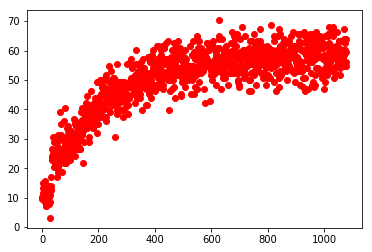

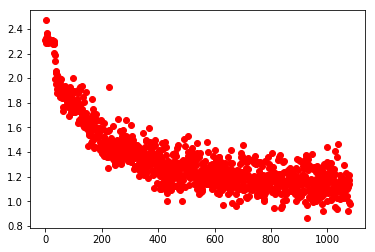

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

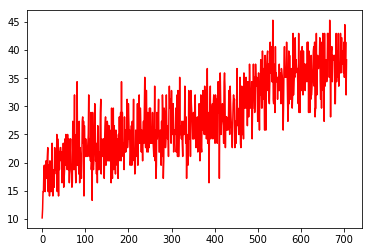

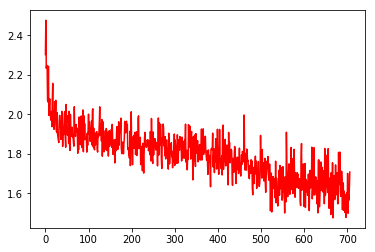

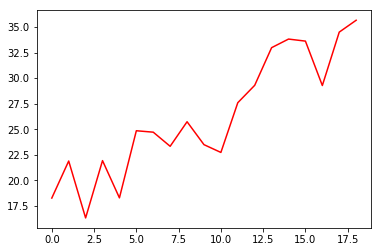

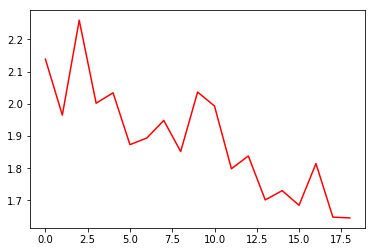

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()